# Section 4.1.2. VAE

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------------
# Define the VAE model
# -------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, z_dim)
        self.log_var_layer = nn.Linear(hidden_dim, z_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [3]:
# -------------------------------
# Loss function
# -------------------------------
def compute_loss(x, x_reconstructed, mu, log_var):
    """
    MSE based reconstruction loss and KL divergence loss for VAE.
    """
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # total loss
    loss = recon_loss + kl_loss
    return loss

# -------------------------------
# Training
# -------------------------------
def train_vae(model, dataloader, optimizer, num_epochs, device):
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_reconstructed, mu, log_var = model(x)
            loss = compute_loss(x, x_reconstructed, mu, log_var)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 3 == 0 or epoch == 1:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')

## 1. Training Stage

In [4]:
filepath = '../dataset/hts_example.csv'
z_dim = 64
hidden_dim = 512
learning_rate = 1e-3
batch_size = 512
num_epochs = 36

ground_truth_df, data_tensor, num_categories = load_and_preprocess_data(filepath, device)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# VAE model and optimizer creation
input_dim = data_tensor.shape[1]
vae_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training
train_vae(vae_model, dataloader, optimizer, num_epochs, device)

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.
Epoch [1/36], Loss: 1183384.8304
Epoch [3/36], Loss: 745120.0917
Epoch [6/36], Loss: 707240.7400
Epoch [9/36], Loss: 697446.3817
Epoch [12/36], Loss: 692107.7870
Epoch [15/36], Loss: 688183.0363
Epoch [18/36], Loss: 684546.4216
Epoch [21/36], Loss: 684169.3375
Epoch [24/36], Loss: 682056.6902
Epoch [27/36], Loss: 681019.5977
Epoch [30/36], Loss: 679943.3220
Epoch [33/36], Loss: 678901.2654
Epoch [36/36], Loss: 679076.9126


# 2. Testing Stage

In [5]:
def generate_samples(model, num_samples, z_dim, device, columns, num_categories):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, z_dim).to(device)
        samples = model.decode(z).cpu().numpy()
    generated_df = pd.DataFrame(samples, columns=columns)
    
    for column in columns:
        max_cat = num_categories[column] - 1
        generated_df[column] = np.floor(generated_df[column]).astype(int)
        generated_df[column] = np.clip(generated_df[column], 0, max_cat)
    return generated_df

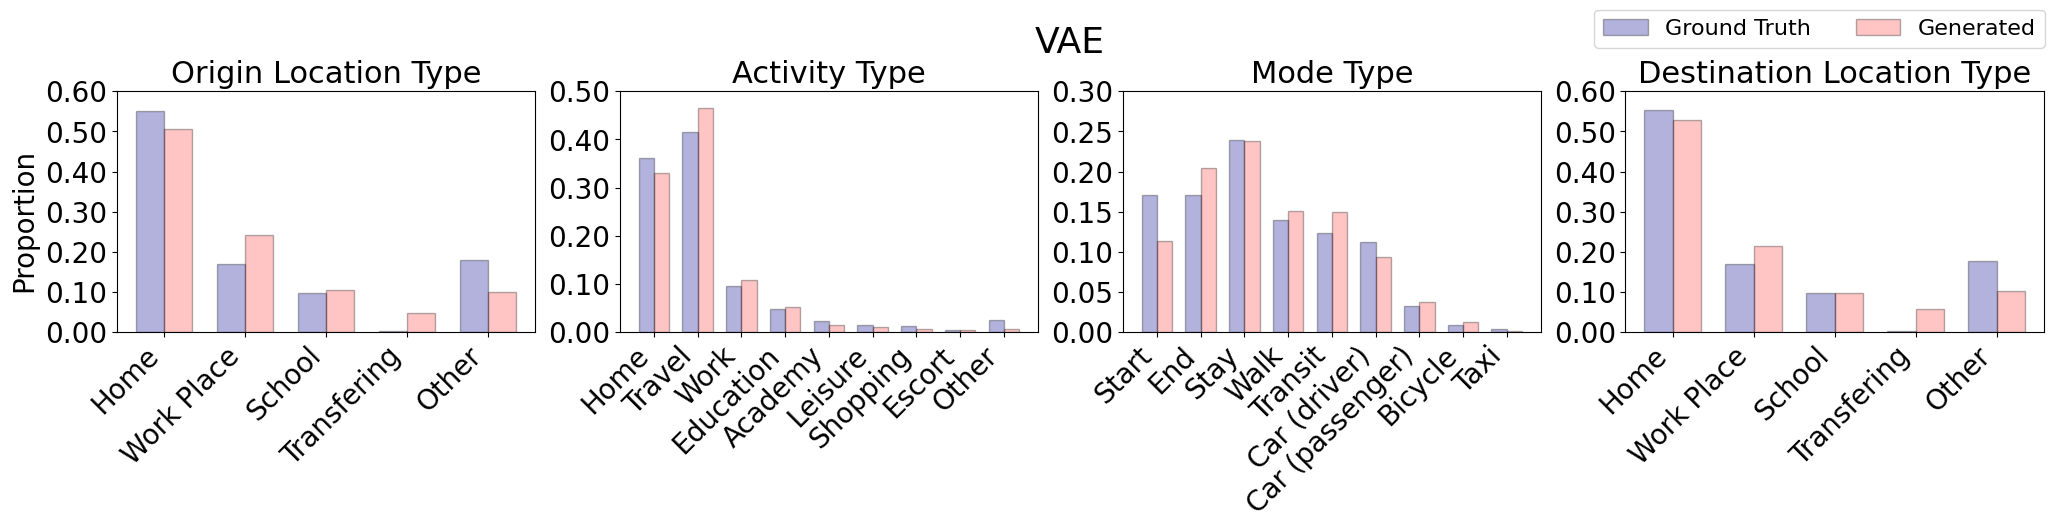

In [6]:
model_name = 'VAE'
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples = 3000

generated_df = generate_samples(vae_model, num_samples, z_dim, device, columns, num_categories)

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

visualize_results(model_name, ground_truth_df, generated_df, columns, xtick_labels_list)